In [ ]:
!pip install -U tensorflow_datasets

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_datasets as tfds


import math
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm


##Импортируем набор данных Fashion MNIST


набор данных Fashion MNIST, который содержит 70 000 изображений элементов одежды в 10 категориях в градациях серого

Мы воспользуемся 60 000 изображениями для тренировки сети и 10 000 изображениями для проверки точности обучения и классификации изображений.

![alt text](https://tensorflow.org/images/fashion-mnist-sprite.png)

In [ ]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteK9DGGN/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteK9DGGN/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


Имеем два набора train_dataset - на нем мы обучаем нейронку
и
test_dataset - на нем мы будем тестировать как работает

Изображения представляют собой двумерные массивы 28х28, где значения в каждой ячейке могут быть в интервале [0, 255].
Метки - массив целых чисел, где каждое значение в интервале [0, 9].

Каждое изображение относится к одной метке

In [ ]:
class_names = ['Футболка / топ', "Шорты", "Свитер", "Платье",
              "Плащ", "Сандали", "Рубашка", "Кроссовок", "Сумка",
              "Ботинок"]

In [ ]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print('Тренировочные данные : {}'.format(num_train_examples))
print('Тестовые данные: {}'.format(num_test_examples))

Тренировочные данные : 60000
Тестовые данные: 10000


Значение каждого пикселя в изображении находится в интервале [0,255]. Для того, чтобы модель работала корректно эти значения необходимо нормализовать - привести к значениям в интервале [0,1].



In [ ]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

def mirror(images, labels):
  return tf.image.flip_up_down(images), labels

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize).map(mirror)

Получим вот такое изображение

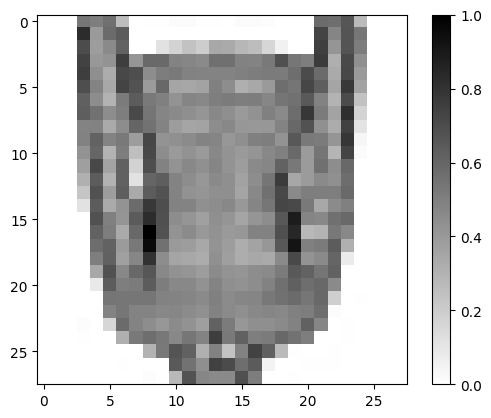

In [ ]:
for image, label in test_dataset.take(1):
  break;
image = image.numpy().reshape((28, 28))

# отрисовываем изображение
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

### Строим модель


Сеть будет  состоять из трёх слоёв:

 - входной tf.keras.layers.Flatten - этот слой преобразует изображения размером 28х28 пикселей в 1D-массив размером 784 (28 * 28). На этом слое у нас нет никаких параметров для обучения, так как этот слой занимается только преобразованием входных данных.

 - скрытый слой tf.keras.layers.Dense - плотносвязный слой из 128 нейронов. Каждый нейрон (узел) принимает на вход все 784 значения с предыдущего слоя, изменяет входные значения согласно внутренним весам и смещениям во время тренировки и возвращает единственное значение на следующий слой.

 - выходной слой ts.keras.layers.Dense - softmax-слой состоит из 10 нейронов, каждый из которых представляет определённый класс элемента одежды. Как и в предыдущем слое, каждый нейрон принимает на вход значения всех 128 нейронов предыдущего слоя.  Сумма всех выходных значений 10 нейронов равна 1. Применем функцию relu

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

###Компилируем модель


Применяем пр  компеляции:
- функция потерь - алгоритм измерения того, насколько далеко находится желаемое значение от спрогнозированного.
- функция оптимизации - агоритм "подгонки" внутренних параметров (весов и смещений) модели для минимизации функции потерь;
- метрики - используются для мониторинга процесса тренировки и тестирования.

In [ ]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

## Тренируем модель

Во-первых, определяем последовательность действий при обучении на тренировочном наборе данных:

1. Повторяем бесконечное количество раз набор входных данных используя метод `dataset.repeat()` (параметр `epochs`, который описан ниже, определяет количество всех обучающих итераций для выполнения)
2. Метод `dataset.shuffle(60000)` перемешивает все изображения для того, чтобы на обучение нашей модели не влиял порядок подачи входных данных.
3. Метод `dataset.batch(32)` сообщает методу тренировки `model.fit` использовать блоки по 32 изображения и метки при обновлении внутренних переменных модели.


In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [ ]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 87s 45ms/step - loss: 0.1297 - accuracy: 0.9524
Epoch 2/10
1875/1875 [==============================] - 84s 45ms/step - loss: 0.1108 - accuracy: 0.9595
Epoch 3/10
1875/1875 [==============================] - 84s 45ms/step - loss: 0.0928 - accuracy: 0.9655
Epoch 4/10
1875/1875 [==============================] - 85s 45ms/step - loss: 0.0750 - accuracy: 0.9721
Epoch 5/10
1875/1875 [==============================] - 92s 49ms/step - loss: 0.0677 - accuracy: 0.9746
Epoch 6/10
1875/1875 [==============================] - 86s 46ms/step - loss: 0.0564 - accuracy: 0.9797
Epoch 7/10
1875/1875 [==============================] - 91s 48ms/step - loss: 0.0467 - accuracy: 0.9830
Epoch 8/10
1875/1875 [==============================] - 93s 50ms/step - loss: 0.0405 - accuracy: 0.9854
Epoch 9/10
1875/1875 [==============================] - 93s 49ms/step - loss: 0.0380 - accuracy: 0.9858
Epoch 10/10
1875/1875 [==============================] - 93s 50m

В процессе тренировки модели значение функции потерь и метрика точности отображаются для каждой обучающей итерации. Эта модель достигает точности около 0.9 (90%) на тренировочных данных.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
print("Точность на тестовом наборе данных: ", test_accuracy)

313/313 [==============================] - 5s 15ms/step - loss: 11.7344 - accuracy: 0.2011
Точность на тестовом наборе данных:  0.20110000669956207


Точность на тестовом наборе данных оказалась меньше точности на тренировочном наборе данных. Это вполне нормально, так как модель была обучена на train_dataset данных. Когда модель обнаруживает изображения, которые она ранее никогда не видела (из набора данных train_dataset), вполне очевидно, что эффективность классификации снизится

Можем воспользоваться обученной моделью для получения предсказаний по некоторым изображениям.

In [ ]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 [==============================] - 0s 35ms/step


In [ ]:
predictions.shape

(32, 10)

Мы можем отобразить все входные изображения и соответствующие предсказания модели по 10 классам:

In [ ]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                      100 * np.max(predictions_array),
                                      class_names[true_label]),
                                      color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Давайте взглянем на 0-ое изображение, результат предсказания модели и массив предсказаний.

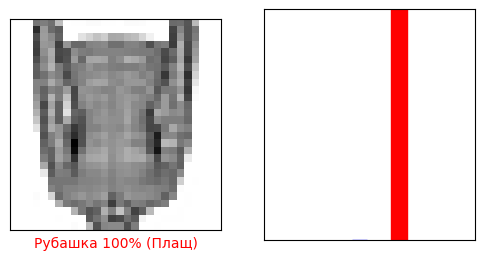

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

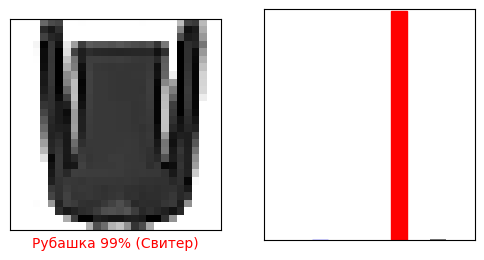

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

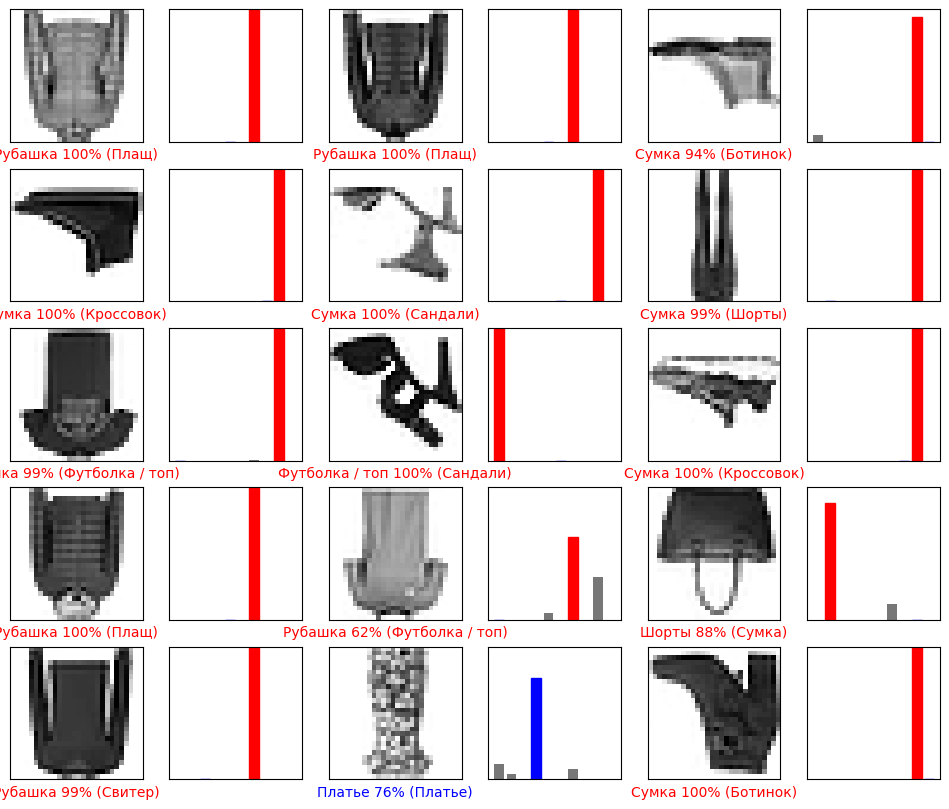

In [ ]:
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i + 1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i + 2)
  plot_value_array(i, predictions, test_labels)

In [ ]:
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [ ]:
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [ ]:
predictions_single = model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 29ms/step
[[4.2468191e-08 5.5240850e-15 5.8644588e-13 1.9458489e-12 1.3385274e-12
  2.8784893e-12 9.9999976e-01 7.7222010e-19 2.7279347e-07 1.3421519e-13]]


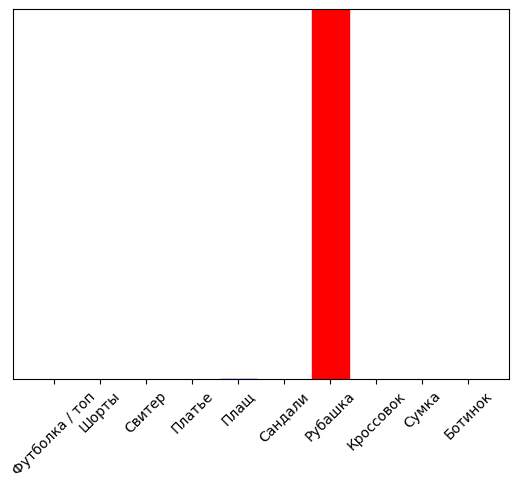

In [ ]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [ ]:
np.argmax(predictions_single[0])

6

Mодель предсказала метку 6 (рубкашка).